In [5]:
import pandas as pd

# Read the Excel file and load the "General answers" sheet into a DataFrame
ga = pd.read_excel("data.xlsx", sheet_name="General answers")

# convert all letters to lowercase in every cell
def to_lowercase(x):
    if isinstance(x, str):
        return x.lower()
    return x
ga = ga.applymap(to_lowercase)

# Read the Excel file and load the "randomized scenarios" sheet into a DataFrame
rs = pd.read_excel("data.xlsx", sheet_name="randomized scenarios")

# convert all letters to lowercase in every cell
rs = rs.applymap(to_lowercase)

# quantify answers
extent = {
    "strongly disagree": 0,
    "disagree": 1,
    "agree": 2,
    "strongly agree": 3,

    "no importance at all": 0,
    "not important": 1,
    "important": 2,
    "extremely important": 3,

    "not at all": 0,
    "slightly": 1,
    "greatly": 2,
    "vitally": 3,

    "very unlikely": 0,
    "somewhat unlikely": 1,
    "somewhat likely": 2,
    "very likely": 3,
}

# Create a mapping of question numbers to column names
question_map = {f"{i+1}": col for i, col in enumerate(ga.columns)}

In [ ]:
import re

# Reload the newly uploaded CSV
rs = pd.read_excel("data.xlsx", sheet_name="randomized scenarios")

# Step 1: Drop any unnamed or irrelevant columns
df_v3_cleaned = rs.loc[:, ~rs.columns.str.contains('^Unnamed')]

# Step 2: Melt into long format
df_long_v3 = df_v3_cleaned.melt(var_name='scenario', value_name='willingness')

# Step 3: Map textual responses to ordinal scale
willingness_map = {
    'Very unlikely': 0,
    'Somewhat unlikely': 1,
    'Somewhat likely': 2,
    'Very likely': 3
}
df_long_v3['willingness_score'] = df_long_v3['willingness'].map(willingness_map)

# Step 4: Extract features
def extract_features_updated(scenario):
    scenario = scenario.lower()

    # Identify topic
    if 'referendum' in scenario:
        topic = 'referendum'
    elif 'leader election' in scenario:
        topic = 'leader_election'
    elif 'participatory budgeting' in scenario:
        topic = 'budgeting'
    else:
        topic = 'unknown'

    # Identify scale and encode as numeric
    if 'school' in scenario or 'workers union' in scenario:
        scale = 1
    elif 'local council' in scenario:
        scale = 2
    elif 'national' in scenario:
        scale = 3
    else:
        scale = None

    # Extract deposit and reward
    deposit_match = re.search(r'deposits (\d+(\.\d+)?)', scenario)
    reward_match = re.search(r'rewards (\d+(\.\d+)?)', scenario)
    no_deposit = 'no deposits' in scenario

    deposit = float(deposit_match.group(1)) if deposit_match else (0.0 if no_deposit else None)
    reward = float(reward_match.group(1)) if reward_match else None

    return pd.Series([topic, scale, deposit, reward])

df_long_v3[['topic', 'scale', 'deposit', 'reward']] = df_long_v3['scenario'].apply(extract_features_updated)

# Step 5: One-hot encode topic
df_encoded_v3 = pd.get_dummies(df_long_v3, columns=['topic'], drop_first=False)

# Step 6: Keep relevant columns and drop NaNs
df_final_v3 = df_encoded_v3.dropna(subset=['willingness_score', 'scale', 'deposit', 'reward'])

# remove the 'scenario' column
df_final_v3 = df_final_v3.drop(columns=['scenario', 'willingness'])

# save the final DataFrame to a CSV file
df_final_v3.to_csv("randomized_scenarios_cleaned.csv", index=False)

                                              scenario        willingness  \
0    A school / workers union leader election, depo...        Very likely   
1    A school / workers union leader election, depo...      Very unlikely   
2    A school / workers union leader election, depo...    Somewhat likely   
3    A school / workers union leader election, depo...  Somewhat unlikely   
4    A school / workers union leader election, depo...      Very unlikely   
..                                                 ...                ...   
220      A national referendum, deposits 10, rewards 1    Somewhat likely   
221      A national referendum, deposits 10, rewards 1  Somewhat unlikely   
222      A national referendum, deposits 10, rewards 1  Somewhat unlikely   
223      A national referendum, deposits 10, rewards 1    Somewhat likely   
224      A national referendum, deposits 10, rewards 1  Somewhat unlikely   

     willingness_score            topic  scale  deposit  reward  
0        

In [ ]:
print("-- Importance of factors in a voting system --")

for i in range(11, 16):
    average = ga[question_map[str(i)]].replace(extent).mean()
    print(question_map[str(i)], average)

-- Importance of factors in a voting system --
[11] Convenience 2.2580645161290325
[12] Anonymity 2.3225806451612905
[13] Ballot Secrecy 2.3548387096774195
[14] Ballot integrity (the value of the vote not being able to change) 2.7419354838709675
[15] Verifiability (being able to check that the vote I submitted matches the vote on the system) 2.5806451612903225


In [7]:
from scipy.stats import ttest_rel

print("-- Is user experience beyond expecation? --")

print("\nTrust to the host comparison:")
average_8 = ga[question_map["8"]].replace(extent).mean()
print(question_map["8"], average_8)

average_19 = ga[question_map["19"]].replace(extent).mean()
print(question_map["19"], average_19)

print("\nTrust to third parties comparison:")
average_9 = ga[question_map["9"]].replace(extent).mean()
print(question_map["9"], average_9)

average_20 = ga[question_map["20"]].replace(extent).mean()
print(question_map["20"], average_20)

print("\nTrust of anonymity comparison:")
average_10 = ga[question_map["10"]].replace(extent).mean()
print(question_map["10"], average_10)

average_21 = ga[question_map["21"]].replace(extent).mean()
print(question_map["21"], average_21)

print("\nConvinence comparison:")
average_16 = ga[question_map["16"]].replace(extent).mean()
print(question_map["16"], average_16)

average_22 = ga[question_map["22"]].replace(extent).mean()
print(question_map["22"], average_22)

# Perform t-tests to check if the differences are significant
print("\nSignificance tests:")

# Trust to the host
t_stat, p_value = ttest_rel(
    ga[question_map["8"]].replace(extent).dropna(),
    ga[question_map["19"]].replace(extent).dropna()
)
print(f"Trust to the host: t-stat={t_stat:.2f}, p-value={p_value:.4f}")

# Trust to third parties
t_stat, p_value = ttest_rel(
    ga[question_map["9"]].replace(extent).dropna(),
    ga[question_map["20"]].replace(extent).dropna()
)
print(f"Trust to third parties: t-stat={t_stat:.2f}, p-value={p_value:.4f}")

# Trust of anonymity
t_stat, p_value = ttest_rel(
    ga[question_map["10"]].replace(extent).dropna(),
    ga[question_map["21"]].replace(extent).dropna()
)
print(f"Trust of anonymity: t-stat={t_stat:.2f}, p-value={p_value:.4f}")

# Convenience
t_stat, p_value = ttest_rel(
    ga[question_map["16"]].replace(extent).dropna(),
    ga[question_map["22"]].replace(extent).dropna()
)
print(f"Convenience: t-stat={t_stat:.2f}, p-value={p_value:.4f}")


-- Is user experience beyond expecation? --

Trust to the host comparison:
[8] The results of the voting will be untampered with by the host.  1.935483870967742
[19] I trust that the voting result in this study is untampered with by the host. 2.2903225806451615

Trust to third parties comparison:
[9] The results of the voting will be untampered with by third parties 1.935483870967742
[20] I trust that the voting result in this study is untampered with by third parties. 2.193548387096774

Trust of anonymity comparison:
[10] My vote is completely anonymous. 1.7096774193548387
[21] I trust that my vote in this study is completely anonymous. 2.161290322580645

Convinence comparison:
[16] I expect it will be simple to cast my vote in this trial blockchain-based e-election system 2.193548387096774
[22] I found it simple to cast my vote in this trial blockchain-based e-election system. 2.4193548387096775

Significance tests:
Trust to the host: t-stat=-3.25, p-value=0.0029
Trust to third parti

In [ ]:
print("-- Weight of each factor in the secret holder utility function --")

average_24 = ga[question_map["24"]].replace(extent).mean()
print("Monetory reward importance:", average_24)

average_25 = ga[question_map["25"]].replace(extent).mean()
print("Goodwill importance:", average_25)

average_26 = ga[question_map["26"]].replace(extent).mean()
print("Obligation importance:", average_26)

average_27 = ga[question_map["27"]].replace(extent).mean()
print("Penalty importance:", average_27)

-- Weight of each factor in the secret holder utility function --
Monetory reward importance: 2.0
Goodwill importance: 1.3870967741935485
Obligation importance: 1.3870967741935485
Penalty importance: 1.2903225806451613


In [ ]:
print("-- Do people response differently in voting topics with different chariteristics --")
for i in range(29, 36):
    average = ga[question_map[str(i)]].replace(extent).mean()
    print(question_map[str(i)], average)

-- Do people response differently in voting topics with different chariteristics --
[29] a topic that is relevant for me 2.4193548387096775
[30] a critical topic 2.3225806451612905
[31] a controversial topic 1.935483870967742
[32] a political topic 1.8709677419354838
[33] a topic with polarized opinions 1.6774193548387097
[34] an interesting topic 2.2580645161290325
[35] topics with long term impact 2.3870967741935485


-- Randomized scenarios regression --
Mean Squared Error: 0.9121
R-squared: -0.1384
                 Feature  Coefficient
0                  scale     0.203659
1                deposit    -0.085178
2                 reward     0.065355
3        topic_budgeting    -0.087989
4  topic_leader_election     0.209755
5       topic_referendum    -0.121766
-- Randomized scenarios Ordinary Least Squares --
                            OLS Regression Results                            
Dep. Variable:      willingness_score   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.073
Date:                Mon, 28 Apr 2025   Prob (F-statistic):             0.0720
Time:                        01:38:49   Log-Likelihood:                -201.21
No. Observations:                 155   AIC:                             414.4
Df Residuals:                     149   BIC:   

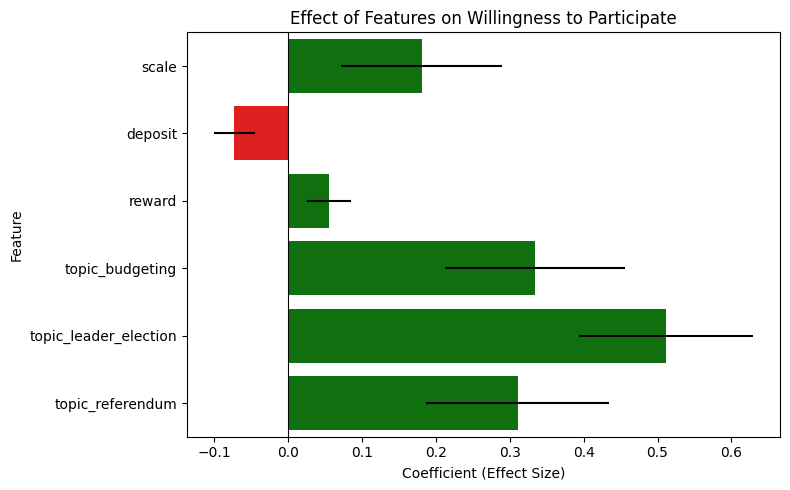

In [19]:
print("-- Randomized scenarios regression --")
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the cleaned data
df = pd.read_csv("randomized_scenarios_cleaned.csv")

# Step 2: Define features (X) and target (y)
X = df.drop(columns=["willingness_score"])
y = df["willingness_score"]

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and fit regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Step 7: Optional - Show model coefficients
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
})
print(coefficients)

print("-- Randomized scenarios Ordinary Least Squares --")
import statsmodels.api as sm
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

import matplotlib.pyplot as plt
import seaborn as sns
# Extract coefficients (excluding the intercept)
coefs = model.params.drop("const")
errors = model.bse.drop("const")  # standard errors

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    x=coefs.values,
    y=coefs.index,
    orient="h",
    palette=["green" if c > 0 else "red" for c in coefs.values],
    xerr=errors.values  # add error bars
)

plt.axvline(0, color='black', linewidth=0.8)  # vertical line at 0
plt.title("Effect of Features on Willingness to Participate")
plt.xlabel("Coefficient (Effect Size)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()